In [7]:
from pathlib import Path
import sys

# Set paths explicitly
PROJECT_ROOT = Path(r'C:\Users\a7654\OneDrive\Ambiente de Trabalho\STUDY\projects\projects\mibel-intelligence')
sys.path.insert(0, str(PROJECT_ROOT))

from src.data.build_panel import build_main_panel

print("Building panel...")
panel = build_main_panel(
    start_date='2022-01-01',
    end_date='2023-12-31',
    countries=['ES', 'PT']
)

print(f"✅ Built: {len(panel):,} rows")

INFO:src.data.build_panel:============================================================
INFO:src.data.build_panel:BUILDING MAIN ANALYSIS PANEL
INFO:src.data.build_panel:============================================================
INFO:src.data.build_panel:1. Creating hour index...
INFO:src.utils.timezone_utils:Created hour index: 17,520 hours from 2022-01-01 to 2023-12-31
INFO:src.data.build_panel:2. Loading prices...
INFO:src.data.build_panel:Building price panel...
INFO:src.data.build_panel:Price panel: 0 rows, 0 countries
INFO:src.data.build_panel:3. Loading weather...
INFO:src.data.build_panel:Building weather panel...
INFO:src.data.build_panel:Weather panel: 0 rows
INFO:src.data.build_panel:4. Loading cross-border flows...
INFO:src.data.build_panel:Building flows panel...
INFO:src.data.build_panel:Flows panel: 0 rows, 0 flow pairs
INFO:src.data.build_panel:5. Merging all data sources...


Building panel...
DEBUG - Price panel loaded:
  Total rows: 0
  Countries: []
  Rows per country: Series([], dtype: int64)

Sample data:
Empty DataFrame
Columns: [timestamp, country, price_eur_mwh]
Index: []


Countries: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.80it/s]
INFO:src.data.build_panel:6. Adding cross-border flows...
INFO:src.data.build_panel:7. Adding time features...
INFO:src.data.build_panel:8. Data quality checks...
INFO:src.data.build_panel:  Total rows: 35,040
INFO:src.data.build_panel:  Date range: 2022-01-01 00:00:00+00:00 to 2023-12-31 23:00:00+00:00
INFO:src.data.build_panel:  Countries: ['ES', 'PT']
INFO:src.data.build_panel:  Missing prices: 35,040 (100.0%)
INFO:src.data.build_panel:Saved to: C:\Users\a7654\OneDrive\Ambiente de Trabalho\STUDY\projects\projects\mibel-intelligence\data\processed\main_panel_2022-01-01_2023-12-31.parquet
INFO:src.data.build_panel:============================================================
INFO:src.data.build_panel:PANEL CONSTRUCTION COMPLETE
INFO:src.data.build_panel:============================================================


✅ Built: 35,040 rows


In [8]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path(r'C:\Users\a7654\OneDrive\Ambiente de Trabalho\STUDY\projects\projects\mibel-intelligence')
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'

panel_file = list(PROCESSED_DIR.glob("main_panel_*.parquet"))[-1]  # Get most recent
df = pd.read_parquet(panel_file)

print(f"✅ Loaded: {len(df):,} rows")

✅ Loaded: 384 rows


In [14]:
import pandas as pd
from pathlib import Path
from src.utils.db_utils import get_connection
from src.utils.db_schema import create_schema

print("Loading OMIE data...")

# Create schema
create_schema()

# Get connection
conn = get_connection(readonly=False)

# Clear existing
conn.execute("DELETE FROM prices_day_ahead")
conn.commit()
print("✓ Cleared database")

# Find files
raw_dir = Path(r'C:\Users\a7654\OneDrive\Ambiente de Trabalho\STUDY\projects\projects\mibel-intelligence\data\raw\omie')
price_files = list(raw_dir.glob("day_ahead_prices_*.parquet"))

print(f"\nFound {len(price_files)} files:")
for f in price_files:
    print(f"  - {f.name}")

if len(price_files) == 0:
    print("\n❌ NO FILES FOUND!")
    print(f"Checked in: {raw_dir}")
    print("Download data first!")
else:
    # Process files
    total_rows = 0
    
    for file in price_files[:1]:  # Just do first file as test
        print(f"\nProcessing {file.name}...")
        df = pd.read_parquet(file)
        
        price_spain = df[df['CONCEPT'] == 'PRICE_SP'].copy()
        
        print(f"  Spain rows: {len(price_spain)}")
        
        # Process just first day as test
        if len(price_spain) > 0:
            row = price_spain.iloc[0]
            date = pd.Timestamp(row['DATE']).date()
            
            print(f"  Processing date: {date}")
            
            for hour_num in range(1, 25):
                hour_col = f'H{hour_num}'
                
                if hour_col in row and pd.notna(row[hour_col]):
                    hour_of_day = hour_num - 1
                    timestamp = pd.Timestamp(f"{date} {hour_of_day:02d}:00:00", tz='UTC')
                    price = float(row[hour_col])
                    
                    conn.execute("""
                        INSERT OR REPLACE INTO prices_day_ahead 
                        (timestamp, country, price_eur_mwh, energy_mwh)
                        VALUES (?, ?, ?, ?)
                    """, [timestamp, 'ES', price, None])
                    
                    total_rows += 1
            
            conn.commit()
            print(f"  ✓ Inserted {total_rows} rows")
    
    # Verify
    result = conn.execute("SELECT COUNT(*) as count FROM prices_day_ahead").fetchdf()
    print(f"\n✅ Database now has {result['count'].iloc[0]} rows")
    
    if result['count'].iloc[0] > 0:
        sample = conn.execute("SELECT * FROM prices_day_ahead LIMIT 5").fetchdf()
        print("\nSample:")
        print(sample)
    
    conn.close()

INFO:src.utils.db_schema:Creating database schema...
INFO:src.utils.db_schema:Schema created successfully


Loading OMIE data...
✓ Cleared database

Found 8 files:
  - day_ahead_prices_2022-01-01_2022-03-31.parquet
  - day_ahead_prices_2022-04-01_2022-06-30.parquet
  - day_ahead_prices_2022-07-01_2022-09-30.parquet
  - day_ahead_prices_2022-10-01_2022-12-31.parquet
  - day_ahead_prices_2023-01-01_2023-03-31.parquet
  - day_ahead_prices_2023-04-01_2023-06-30.parquet
  - day_ahead_prices_2023-07-01_2023-09-30.parquet
  - day_ahead_prices_2023-10-01_2023-12-31.parquet

Processing day_ahead_prices_2022-01-01_2022-03-31.parquet...
  Spain rows: 90
  Processing date: 2022-01-01


BinderException: Binder Error: Conflict target has to be provided for a DO UPDATE operation when the table has multiple UNIQUE/PRIMARY KEY constraints

In [9]:
# Cell 1: Load 2-year panel
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting setup
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

PROCESSED_DIR = Path("../data/processed")

# Load the 2-year panel
panel_file = list(PROCESSED_DIR.glob("main_panel_2022-01-01_2023-12-31.parquet"))[0]
df = pd.read_parquet(panel_file)

print(f"✅ Loaded 2-year panel: {len(df):,} rows")
print(f"📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"🌍 Countries: {sorted(df['country'].unique())}")

# Create period splits
exception_start = pd.Timestamp('2022-06-15', tz='UTC')

pre_exception = df[~df['is_iberian_exception']].copy()
during_exception = df[df['is_iberian_exception']].copy()

print(f"\n📊 Period breakdown:")
print(f"   Pre-exception (Jan-Jun 14, 2022): {len(pre_exception):,} rows")
print(f"   During exception (Jun 15, 2022 - Dec 31, 2023): {len(during_exception):,} rows")

# Create country subsets
spain = df[df['country'] == 'ES'].sort_values('timestamp').copy()
portugal = df[df['country'] == 'PT'].sort_values('timestamp').copy()

spain_pre = spain[~spain['is_iberian_exception']].copy()
spain_during = spain[spain['is_iberian_exception']].copy()

print(f"\n✅ Data loaded and segmented")

✅ Loaded 2-year panel: 35,040 rows
📅 Date range: 2022-01-01 00:00:00+00:00 to 2023-12-31 23:00:00+00:00
🌍 Countries: ['ES', 'PT']

📊 Period breakdown:
   Pre-exception (Jan-Jun 14, 2022): 7,920 rows
   During exception (Jun 15, 2022 - Dec 31, 2023): 27,120 rows

✅ Data loaded and segmented


In [10]:
import pandas as pd

# Check what's in the panel
print("Panel info:")
print(df.info())

print("\n" + "="*60)
print("First 10 rows:")
print(df.head(10))

print("\n" + "="*60)
print("Price column stats:")
print(f"Total rows: {len(df)}")
print(f"Non-null prices: {df['price_eur_mwh'].notna().sum()}")
print(f"Null prices: {df['price_eur_mwh'].isna().sum()}")

print("\n" + "="*60)
print("Sample timestamps:")
print(df[['timestamp', 'country', 'price_eur_mwh']].head(20))

Panel info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   timestamp             35040 non-null  datetime64[ns, UTC]
 1   country               35040 non-null  object             
 2   price_eur_mwh         0 non-null      object             
 3   temperature_c         0 non-null      float64            
 4   wind_speed_100m       0 non-null      float64            
 5   solar_radiation       0 non-null      float64            
 6   dni                   0 non-null      float64            
 7   cloud_cover           0 non-null      float64            
 8   hour                  35040 non-null  int32              
 9   day_of_week           35040 non-null  int32              
 10  month                 35040 non-null  int32              
 11  year                  35040 non-null  int32            

In [12]:
from src.utils.db_utils import execute_query

# Check what's in database
db_prices = execute_query("""
    SELECT 
        timestamp,
        country,
        price_eur_mwh
    FROM prices_day_ahead
    WHERE country = 'ES'
    ORDER BY timestamp
    LIMIT 10
""")

print("Database (first 10):")
print(db_prices)
print(f"\nDatabase timestamp dtype: {db_prices['timestamp'].dtype}")

print("\n" + "="*60)
print("Panel (first 10):")
print(df[df['country'] == 'ES'][['timestamp', 'price_eur_mwh']].head(10))
print(f"\nPanel timestamp dtype: {df['timestamp'].dtype}")

# Check if timestamps match
db_ts = db_prices['timestamp'].iloc[0]
panel_ts = df['timestamp'].iloc[0]

print("\n" + "="*60)
print("Timestamp comparison:")
print(f"Database first: {db_ts} (type: {type(db_ts)})")
print(f"Panel first: {panel_ts} (type: {type(panel_ts)})")
print(f"Equal? {db_ts == panel_ts}")

Database (first 10):
Empty DataFrame
Columns: [timestamp, country, price_eur_mwh]
Index: []

Database timestamp dtype: datetime64[us]

Panel (first 10):
                  timestamp price_eur_mwh
0 2022-01-01 00:00:00+00:00          None
1 2022-01-01 01:00:00+00:00          None
2 2022-01-01 02:00:00+00:00          None
3 2022-01-01 03:00:00+00:00          None
4 2022-01-01 04:00:00+00:00          None
5 2022-01-01 05:00:00+00:00          None
6 2022-01-01 06:00:00+00:00          None
7 2022-01-01 07:00:00+00:00          None
8 2022-01-01 08:00:00+00:00          None
9 2022-01-01 09:00:00+00:00          None

Panel timestamp dtype: datetime64[ns, UTC]


IndexError: single positional indexer is out-of-bounds

In [13]:
from pathlib import Path

db_path = Path(r'C:\Users\a7654\OneDrive\Ambiente de Trabalho\STUDY\projects\projects\mibel-intelligence\data\mibel.duckdb')

if db_path.exists():
    size_mb = db_path.stat().st_size / (1024 * 1024)
    print(f"Database file: {db_path}")
    print(f"Size: {size_mb:.2f} MB")
    
    if size_mb < 1:
        print("\n⚠️ Database is very small - probably empty")
    else:
        print(f"\n✅ Database has data")
else:
    print("❌ Database file doesn't exist!")

Database file: C:\Users\a7654\OneDrive\Ambiente de Trabalho\STUDY\projects\projects\mibel-intelligence\data\mibel.duckdb
Size: 0.76 MB

⚠️ Database is very small - probably empty


C:\Users\a7654\OneDrive\Ambiente de Trabalho\STUDY\projects\projects\mibel-intelligence\venv\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\a7654\AppData\Local\Temp\ipykernel_27880\4255331308.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = spain.set_index('timestamp').resample('M')['price_eur_mwh'].mean()
C:\Users\a7654\OneDrive\Ambiente de Trabalho\STUDY\projects\projects\mibel-intelligence\venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\a7654\OneDrive\Ambiente de Trabalho\STUDY\projects\projects\mibel-intelligence\venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


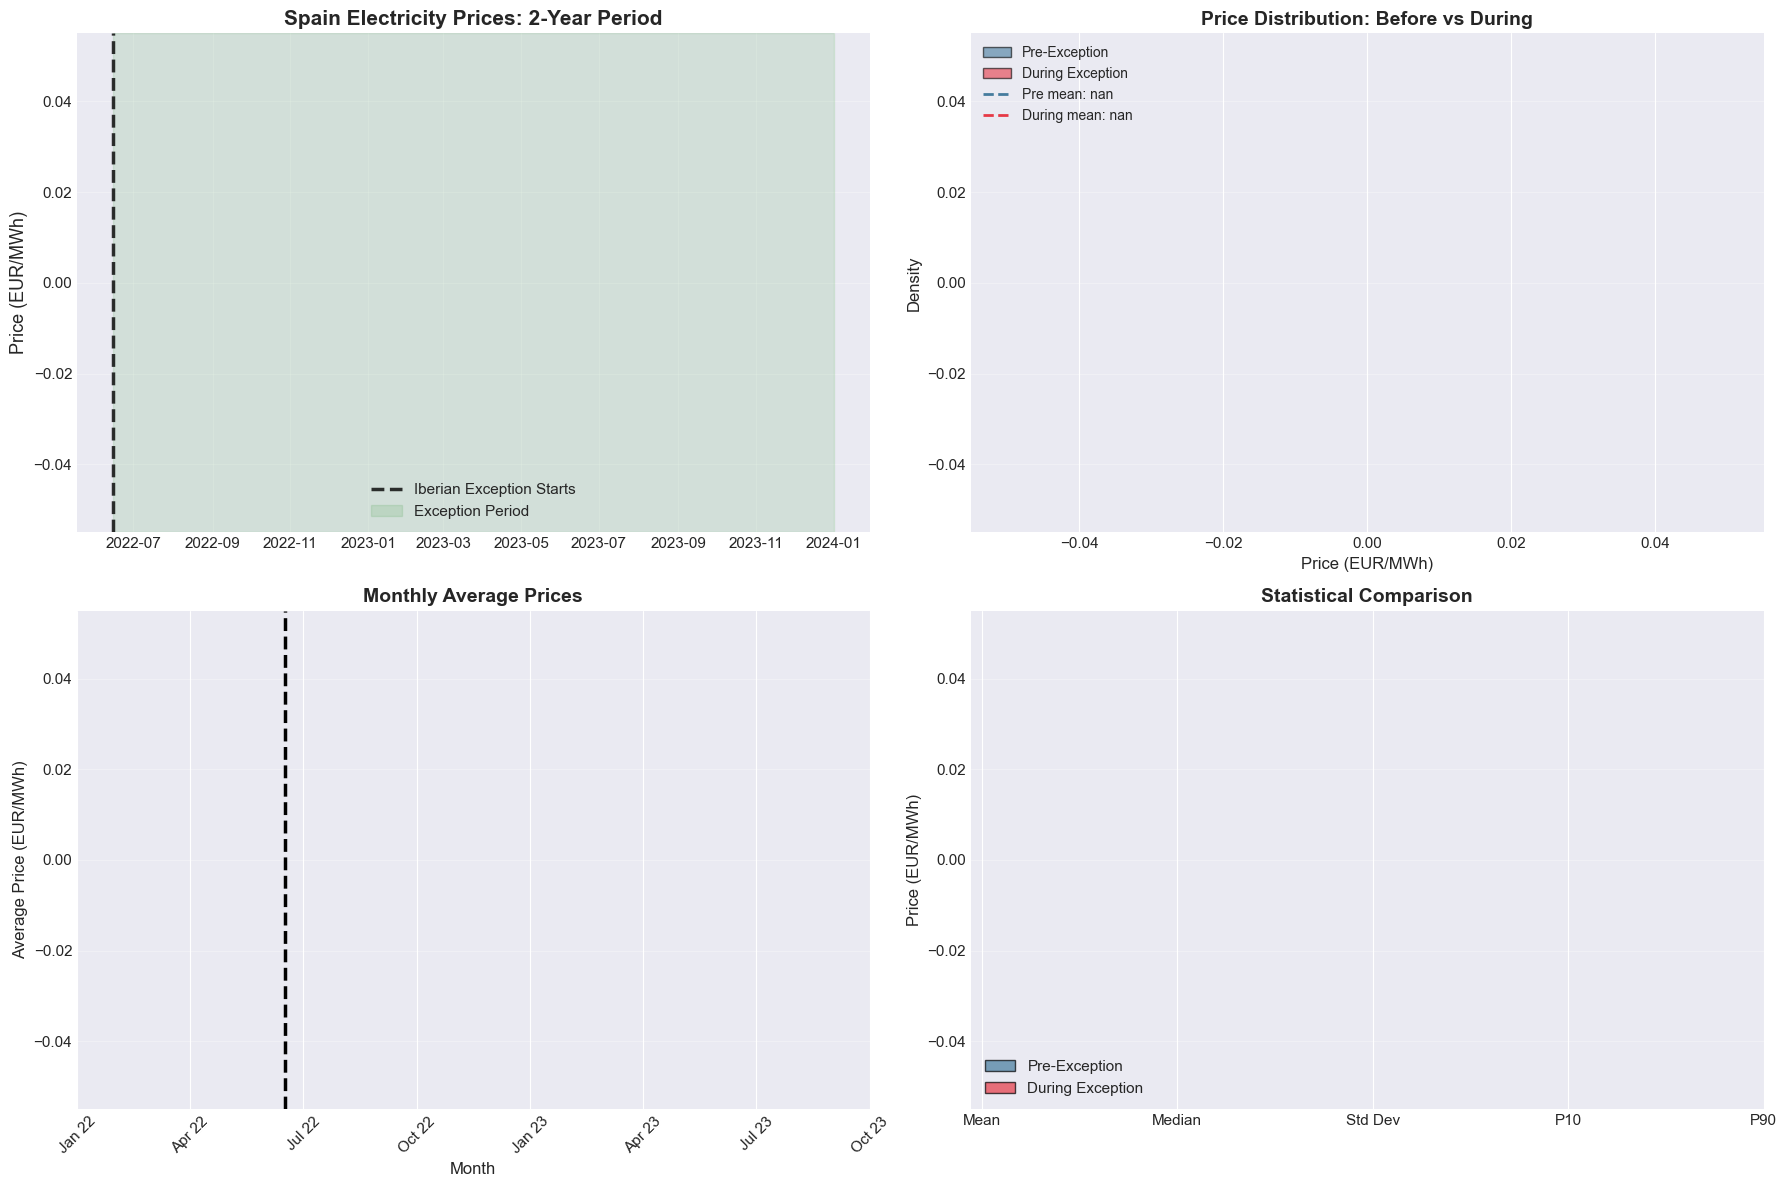

 IBERIAN EXCEPTION IMPACT - SPAIN PRICES

📊 Pre-Exception (Jan 1 - Jun 14, 2022):
   Period: 2022-01-01 to 2022-06-14
   Hours: 3,960
   Mean: nan EUR/MWh
   Median: nan EUR/MWh
   Std Dev: nan EUR/MWh
   Min: nan EUR/MWh
   Max: nan EUR/MWh

📊 During Exception (Jun 15, 2022 - Dec 31, 2023):
   Period: 2022-06-15 to 2023-12-31
   Hours: 13,560
   Mean: nan EUR/MWh
   Median: nan EUR/MWh
   Std Dev: nan EUR/MWh
   Min: nan EUR/MWh
   Max: nan EUR/MWh

💰 Impact:
   Absolute change: +nan EUR/MWh
   Percentage change: +nan%
   ⚠️ Prices INCREASED by nan EUR/MWh during the exception


C:\Users\a7654\OneDrive\Ambiente de Trabalho\STUDY\projects\projects\mibel-intelligence\venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\a7654\OneDrive\Ambiente de Trabalho\STUDY\projects\projects\mibel-intelligence\venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [11]:
# Cell 2: Iberian Exception Impact Analysis

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. Full time series with intervention
ax1.plot(spain['timestamp'], spain['price_eur_mwh'], 
         linewidth=0.8, alpha=0.7, color='#E63946')
ax1.axvline(exception_start, color='black', linestyle='--', linewidth=2.5, 
           label='Iberian Exception Starts', alpha=0.8)
ax1.axvspan(exception_start, spain['timestamp'].max(), 
           alpha=0.1, color='green', label='Exception Period')
ax1.set_ylabel('Price (EUR/MWh)', fontsize=13)
ax1.set_title('Spain Electricity Prices: 2-Year Period', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Distribution comparison
ax2.hist(spain_pre['price_eur_mwh'].dropna(), bins=50, alpha=0.6, 
         color='#457B9D', label='Pre-Exception', density=True, edgecolor='black')
ax2.hist(spain_during['price_eur_mwh'].dropna(), bins=50, alpha=0.6, 
         color='#E63946', label='During Exception', density=True, edgecolor='black')
ax2.axvline(spain_pre['price_eur_mwh'].mean(), color='#457B9D', 
           linestyle='--', linewidth=2, label=f'Pre mean: {spain_pre["price_eur_mwh"].mean():.1f}')
ax2.axvline(spain_during['price_eur_mwh'].mean(), color='#E63946', 
           linestyle='--', linewidth=2, label=f'During mean: {spain_during["price_eur_mwh"].mean():.1f}')
ax2.set_xlabel('Price (EUR/MWh)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Price Distribution: Before vs During', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Monthly average prices
monthly = spain.set_index('timestamp').resample('M')['price_eur_mwh'].mean()
colors = ['#457B9D' if m < exception_start else '#E63946' for m in monthly.index]
ax3.bar(range(len(monthly)), monthly.values, color=colors, alpha=0.7, edgecolor='black')
ax3.axvline(5.5, color='black', linestyle='--', linewidth=2.5)  # June 2022
ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Average Price (EUR/MWh)', fontsize=12)
ax3.set_title('Monthly Average Prices', fontsize=14, fontweight='bold')
ax3.set_xticks(range(0, len(monthly), 3))
ax3.set_xticklabels([monthly.index[i].strftime('%b %y') for i in range(0, len(monthly), 3)], rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Statistical comparison
stats_labels = ['Mean', 'Median', 'Std Dev', 'P10', 'P90']
pre_stats = [
    spain_pre['price_eur_mwh'].mean(),
    spain_pre['price_eur_mwh'].median(),
    spain_pre['price_eur_mwh'].std(),
    spain_pre['price_eur_mwh'].quantile(0.1),
    spain_pre['price_eur_mwh'].quantile(0.9)
]
during_stats = [
    spain_during['price_eur_mwh'].mean(),
    spain_during['price_eur_mwh'].median(),
    spain_during['price_eur_mwh'].std(),
    spain_during['price_eur_mwh'].quantile(0.1),
    spain_during['price_eur_mwh'].quantile(0.9)
]

x = np.arange(len(stats_labels))
width = 0.35
bars1 = ax4.bar(x - width/2, pre_stats, width, label='Pre-Exception', 
                color='#457B9D', alpha=0.7, edgecolor='black')
bars2 = ax4.bar(x + width/2, during_stats, width, label='During Exception', 
                color='#E63946', alpha=0.7, edgecolor='black')

ax4.set_ylabel('Price (EUR/MWh)', fontsize=12)
ax4.set_title('Statistical Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(stats_labels)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("="*80)
print(" IBERIAN EXCEPTION IMPACT - SPAIN PRICES")
print("="*80)

print(f"\n📊 Pre-Exception (Jan 1 - Jun 14, 2022):")
print(f"   Period: {spain_pre['timestamp'].min().date()} to {spain_pre['timestamp'].max().date()}")
print(f"   Hours: {len(spain_pre):,}")
print(f"   Mean: {spain_pre['price_eur_mwh'].mean():.2f} EUR/MWh")
print(f"   Median: {spain_pre['price_eur_mwh'].median():.2f} EUR/MWh")
print(f"   Std Dev: {spain_pre['price_eur_mwh'].std():.2f} EUR/MWh")
print(f"   Min: {spain_pre['price_eur_mwh'].min():.2f} EUR/MWh")
print(f"   Max: {spain_pre['price_eur_mwh'].max():.2f} EUR/MWh")

print(f"\n📊 During Exception (Jun 15, 2022 - Dec 31, 2023):")
print(f"   Period: {spain_during['timestamp'].min().date()} to {spain_during['timestamp'].max().date()}")
print(f"   Hours: {len(spain_during):,}")
print(f"   Mean: {spain_during['price_eur_mwh'].mean():.2f} EUR/MWh")
print(f"   Median: {spain_during['price_eur_mwh'].median():.2f} EUR/MWh")
print(f"   Std Dev: {spain_during['price_eur_mwh'].std():.2f} EUR/MWh")
print(f"   Min: {spain_during['price_eur_mwh'].min():.2f} EUR/MWh")
print(f"   Max: {spain_during['price_eur_mwh'].max():.2f} EUR/MWh")

print(f"\n💰 Impact:")
mean_diff = spain_during['price_eur_mwh'].mean() - spain_pre['price_eur_mwh'].mean()
pct_change = (mean_diff / spain_pre['price_eur_mwh'].mean()) * 100

print(f"   Absolute change: {mean_diff:+.2f} EUR/MWh")
print(f"   Percentage change: {pct_change:+.1f}%")

if mean_diff < 0:
    print(f"   ✅ Prices DECREASED by {abs(mean_diff):.2f} EUR/MWh during the exception")
    savings = abs(mean_diff) * len(spain_during)
    print(f"   💡 Estimated savings: {savings:,.0f} EUR·h over the period")
else:
    print(f"   ⚠️ Prices INCREASED by {mean_diff:.2f} EUR/MWh during the exception")